# Anticipez les besoins en consommation de bâtiments
# Prédiction Consommation



## Sommaire

* Importation des librairies et du jeu de données
* Préparation des jeux données
* Encodage des données
* Création des jeux de données Entrainement / test
* Test des modèles et recherche des hyper paramètres
        * Dummy Regressor / Base line Regression linéaire
            * Dummy Regressor
            * Base Line - Régression linéaire
            * Metrics
            * Feature Importance
            * Prévisions en fonction de l'erreur / des valeurs réelles
        * Elastic Net
            * Metrics
            * Feature Importance
            * Previsions en fonction de l'erreur / des valeurs réelles
        * KNN
            * Metrics
            * Previsions en fonction de l'erreur / des valeurs réelles
        * SVR
            * Metrics
            * Previsions en fonction de l'erreur / des valeurs réelles
        * Random Forest Regressor
            * Metrics
            * Feature Importance
            * Previsions en fonction de l'erreur / des valeurs réelles
        * XGBOOST
            * Metrics
            * Feature Importance
* Comparaison des modèles selon les datasets
    * Dataframe X1
    * Dataframe X2
    * Dataframe X3
    * Classement des modèles par le R2
    * Metrics des modèles
* Test des modèles non optimisé avec l'ENERGYSTAR Score
    * Préparation des données
    * Création des jeux de données Entrainement / test
* Test des modèles avec optimisation des Hyperparamètres
    * Catalogues des hyper Paramètres
    * Dataframe X1
    * Dataframe X2
    * Dataframe X3
    * Dataset ENERGYSTARScore optimisé
* Test du Random Forest avec l'ENERGYSTAR Score


* Choix du modèle


## Importation des librairies et du jeu de données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import shap
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


In [2]:
def results (var):
        print(var.best_params_)
        pred = var.predict(X_train)
        print('Best score: ', var.best_score_)
        print('Test Accuracy: ', var.score(X_train, y_train))

       # mse = mean_squared_error(X_train, y_train)
       # print('MSE: %2.3f' % mse)

def scaling (dataset):
    scaler = RobustScaler()

    # Séparation des variables catégorielles et numériques
    numerical_features = dataset.select_dtypes(exclude='object')
    numerical_features = numerical_features.fillna(0)
    xscale = scaler.fit_transform(numerical_features)

    categorical_features = dataset.select_dtypes(include='object')


    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(categorical_features)

    # création du nom des features catégoriques
    categorical_columns = [f'{col}_{cat}' for i, col in enumerate(categorical_features.columns)
                        for cat in encoder.categories_[i]]

   #Nous créons un dataframe avec les variables catégoriques auquel nous joignons les features numériques

    one_hot_features = pd.DataFrame(X_encoded,
                                    columns=categorical_columns)
    X = numerical_features.join(one_hot_features)

    return X

# fonction qui donne le résultat des métrics pour chaque modéles

def test(models, X_train, X_test, y_train, y_test):
    results = []
    for i, model in enumerate(models):

        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_test)

        r2_predict = r2_score(y_test, y_pred)
        MAE = mean_absolute_error(y_test, y_pred)
        MSE = mean_squared_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        errors = abs(y_pred - y_test)

        results.append([r2_predict,MAE,MSE,RMSE,np.mean(errors)])

    return pd.DataFrame(results, columns=["R2 Score",'MAE','MSE','RMSE','Erreur moyenne'], index=models.keys())


def models_viz (df):
    plt.subplots(figsize=(10, 10))

    for index, column in enumerate(df.columns):
        plt.subplot(3, 2, index+1)
        sns.barplot(x=df.index, y=column, data=df)
    plt.tight_layout()
    plt.show()

In [3]:
#reglage de l'affichage de données
pd.set_option('display.max_row',250)
pd.set_option('display.max_column',300)
pd.set_option('display.precision', 5)

In [4]:
#Importation du jeu de données
missing_values = ["n/a", "na", "--","nan","NaN"]
data = pd.read_csv('fr_data_clean.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,na_values = missing_values).reset_index()

In [5]:
data.head()

,PropertyGFABuildings,LargestPropertyUseTypeGFA,SteamUse_kBtu,Electricity_kBtu,NaturalGas_kBtu,TotalGHGEmissions,GHGEmissionsIntensity,YearBuilt,SiteEnergyUse_kBtu,ENERGYSTARScore,NumberofFloors,NumberofBuildings,Longitude,Latitude,Neighborhood,Address,PropertyName,PrimaryPropertyType,SiteEnergyUseLog,SourceEUI_kBtu_sfLog,SiteEUI_kBtu_sfLog
0,0.55599,0.60901,0.0,1775076.0,440675.5,1.09341,1.32537,-1.14199,0.62191,73.0,3.0,1.0,-122.33328,47.61242,NaN,NaN,NaN,NaN,14.79591,4.83230,3.90600
1,0.55680,0.55543,2003882.0,3946027.0,1276453.0,1.20533,1.33460,1.06722,0.73947,60.0,12.0,1.0,-122.33799,47.61220,DOWNTOWN,405 Olive way,Mayflower park hotel,Hotel,15.79325,5.21221,4.41522
2,2.04786,2.04639,0.0,3242851.0,5145082.0,2.45394,1.08777,0.07960,2.55073,61.0,11.0,1.0,-122.33393,47.61317,DOWNTOWN,724 Pine street,Paramount Hotel,Hotel,15.94230,5.17671,4.56226
3,0.14396,0.21324,21566554.0,49526664.0,1493800.0,1.18387,1.71341,-1.16704,0.57360,43.0,41.0,1.0,-122.33810,47.61393,DOWNTOWN,1900 5th Avenue,5673-The Westin Seattle,Hotel,18.10030,5.49265,4.57471
4,0.80412,0.92182,0.0,1775076.0,440675.5,1.55600,1.34068,0.46072,1.16067,73.0,3.0,1.0,-122.33328,47.61242,NaN,NaN,NaN,NaN,14.79591,4.83230,3.90600


In [6]:
data = pd.DataFrame(data.fillna(data.median()))

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [7]:
data = pd.DataFrame(data.fillna('Autre'))

In [8]:
data.head()

,PropertyGFABuildings,LargestPropertyUseTypeGFA,SteamUse_kBtu,Electricity_kBtu,NaturalGas_kBtu,TotalGHGEmissions,GHGEmissionsIntensity,YearBuilt,SiteEnergyUse_kBtu,ENERGYSTARScore,NumberofFloors,NumberofBuildings,Longitude,Latitude,Neighborhood,Address,PropertyName,PrimaryPropertyType,SiteEnergyUseLog,SourceEUI_kBtu_sfLog,SiteEUI_kBtu_sfLog
0,0.55599,0.60901,0.0,1775076.0,440675.5,1.09341,1.32537,-1.14199,0.62191,73.0,3.0,1.0,-122.33328,47.61242,Autre,Autre,Autre,Autre,14.79591,4.83230,3.90600
1,0.55680,0.55543,2003882.0,3946027.0,1276453.0,1.20533,1.33460,1.06722,0.73947,60.0,12.0,1.0,-122.33799,47.61220,DOWNTOWN,405 Olive way,Mayflower park hotel,Hotel,15.79325,5.21221,4.41522
2,2.04786,2.04639,0.0,3242851.0,5145082.0,2.45394,1.08777,0.07960,2.55073,61.0,11.0,1.0,-122.33393,47.61317,DOWNTOWN,724 Pine street,Paramount Hotel,Hotel,15.94230,5.17671,4.56226
3,0.14396,0.21324,21566554.0,49526664.0,1493800.0,1.18387,1.71341,-1.16704,0.57360,43.0,41.0,1.0,-122.33810,47.61393,DOWNTOWN,1900 5th Avenue,5673-The Westin Seattle,Hotel,18.10030,5.49265,4.57471
4,0.80412,0.92182,0.0,1775076.0,440675.5,1.55600,1.34068,0.46072,1.16067,73.0,3.0,1.0,-122.33328,47.61242,Autre,Autre,Autre,Autre,14.79591,4.83230,3.90600


In [9]:
# On crée 5 datasets par ordre de complexité qui seront ensuite chacun utilisés en X dans l'entraînement des modèles
# pour voir s'il y un dataset qui obtient de meilleurs résultats que les autres.
X0 = data[['PrimaryPropertyType','PropertyGFABuildings','Neighborhood']]
X1 = data[['PrimaryPropertyType','PropertyGFABuildings']]
X2 = data[['PrimaryPropertyType', 'NumberofBuildings', 'PropertyGFABuildings']]
X3 = data[['PrimaryPropertyType', 'NumberofBuildings', 'PropertyGFABuildings', 'Neighborhood', 'YearBuilt']]
X4 = data[['PrimaryPropertyType', 'NumberofBuildings', 'PropertyGFABuildings', 'Neighborhood', 'YearBuilt', 'ENERGYSTARScore']]

In [10]:
# y
y = data['SiteEnergyUse_kBtu']
y= y.fillna(0)

## Encodage des données

In [11]:
# X = scaling(jeu de données)
X = scaling(X0)

One Hot encoder :
Les algorithmes de machine learning ne fonctionnent pas avec les features catégoriques. Elles doivent être transformées en nombres.
Un one hot encoder est une représentation des valeurs catégoriques en vecteurs binaires. Cela requiert en premier lieu le mappage des données en valeurs entières. Cet entier est un vecteur binaires dans lequel toutes les valeurs sont à 0 à l'exception de la valeur index de ce vecteur qui elle est représenté par un 1.

Nous utiliserons le one hot encoder de scikit learn sur les variables Neigborhood et PrimaryPropertyType. L'inconvenient de cette méthode, est la perte des noms des valeurs, il faut donc créer une fonction pour les récupérer.

Robust scaler :
Les robust scaler sont des algorithme qui sont 'robustes' aux outliers, comme nous avons fait le chois de les conserver... La méthode de fonctionnement du robust scaler est identique à celle du MinMaxScaler : elle permet d'uniformiser les indicateurs des dataframes en les ramenant entre 1 et 0. Cela va nous permettre de créer un indicateur composite qui sera la moyenne pondérée de chaque indicateur. Un coefficient de pondération peut être appliqué à chacun des indicateurs selon leur poids dans le choix. En revanche, le robust scaler prend en compte l'IQR, la distance interquartile, alors que le MinMax scaler s'appuie sur les valeur maximum et minimum. Il n'utilise pas non plus la mediane et la taille des données. Sa formule est la suivante :


                                                (xi-Q1(x))/(Q3(x)-Q1(x))


## Création des jeux de données Entrainement / test

In [12]:
#split des dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

Nous utiliserons, pour notre analyse, un random state de 30.
La modification du random state à une influence majeur sur les modèles, entre autre par rapport à l'Overfiting/Underfiting.

In [13]:
# Affichage des caractéristiques du jeu d'entrainement
print(f"Number of samples: {X_train.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
#print(f"Number of categorical features: {categorical_features}")
#print(f"Number of numerical features: {numerical_features}")

Number of samples: 1184
Number of features: 37


## Test des modèles et recherche des hyperparamètres

#### Dummy Regressor

##### Dummy Regressor

Le DummyRegressor est un régresseur qui prédit toujours la moyenne des objectifs d'entraînement.

Ce régresseur est utile comme simple référence à comparer avec d'autres régresseurs (réels). Il ne doit pas être utilisé pour de vrais problèmes.

In [14]:
# Instanciation du Dummy Regressor
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor()
dummy_reg.fit(X_train, y_train)

# Prediction sur les données de test et affichage de metrics
y_pred = dummy_reg.predict(X_test)
r2 = dummy_reg.score(X_test, y_test)
mse = mean_squared_error(y_pred, y_test)

print
print("R2 : ", r2)
print("MSE : ",mse)

R2 :  -0.016442217473874532
MSE :  0.6759890920376844


##### Régression linéaire

La régression linéaire est un algorithme qui fournit une relation linéaire entre une variable indépendante et une variable dépendante pour prédire le résultat des événements futurs. Il s'agit d'une méthode statistique utilisée en science des données et en apprentissage automatique pour l'analyse prédictive.


In [15]:
# Instanciation de la régression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

training_start_lr = time.perf_counter()
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
training_end_lr = time.perf_counter()


##### Metrics

In [16]:
# MSE permet de regarder le modele qui fait le plus d'erreur
#lr.predict
y_predi = lin_reg.predict(X_train)
MSELinear=mean_squared_error(y_train,y_predi)
print('Notre MSE est égal à %0.2f' %MSELinear)
#mae = mean_absolute_error(y_test, y_predi)
#print('MAE: %.3f' % mae)
mapeLinear= mean_absolute_percentage_error(y_train, y_predi) * 100
print('MAPE :' ,mapeLinear)
# Evaluation du training set
train_time=training_end_lr-training_start_lr
print('Voici le temps de calcul',train_time)
rmseLinear = (np.sqrt(mean_squared_error(y_train, y_predi)))
r2linear= r2_score(y_train, y_predi)
#print('La performance du modèle sur la base d'apprentissage')
#print('--------------------------------------')
print('RMSE est {}'.format(rmseLinear))
print('le score R2 coeff de determination et variation expliquée est %0.2f' %(r2linear))
#print('\n')
print("Test  Accuracy : %.2f"%lin_reg.score(X_test, y_test))
print("Train Accuracy : %.2f"%lin_reg.score(X_train, y_train))

Notre MSE est égal à 0.27
MAPE : 134.07833992276784
Voici le temps de calcul 0.007551040995167568
RMSE est 0.5158451633003374
le score R2 coeff de determination et variation expliquée est 0.57
Test  Accuracy : 0.54
Train Accuracy : 0.57


##### Feature Importance

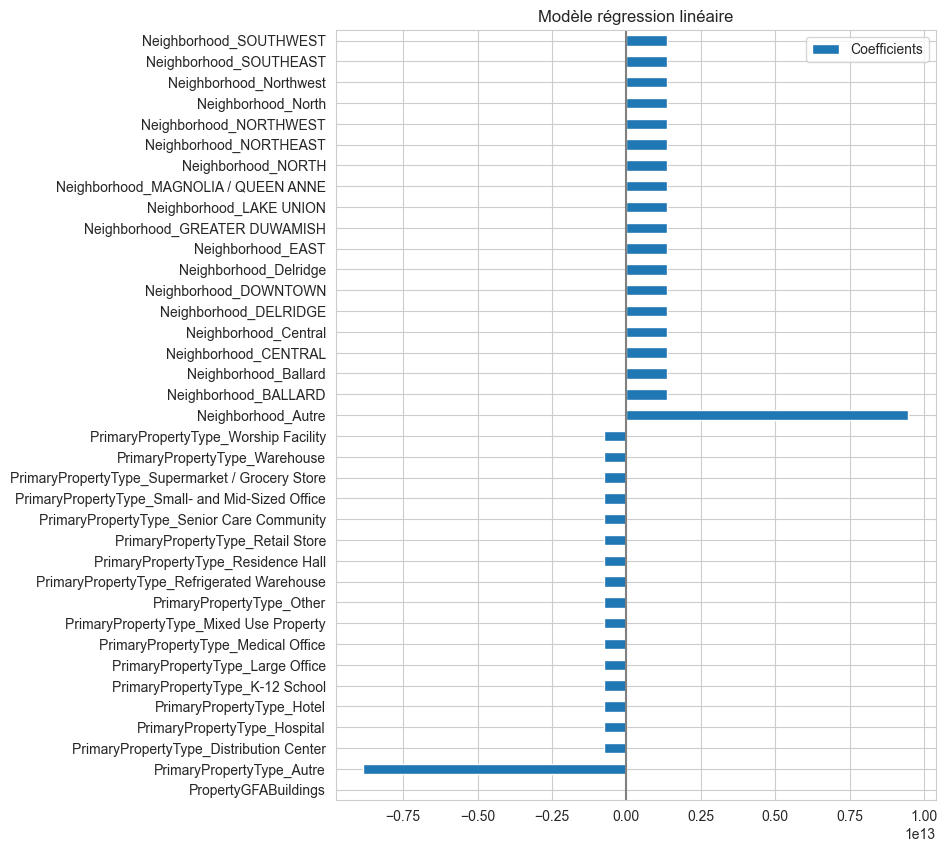

In [17]:
coefs = pd.DataFrame(
    lin_reg.coef_,
    columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(10, 10))
plt.title('Modèle régression linéaire')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

##### Previsions en fonction de l'erreur / des valeurs réelles

In [18]:
y_predi = lin_reg.predict(X_train) #prédiction
erreur=y_predi-y_train #erreur de prédiction

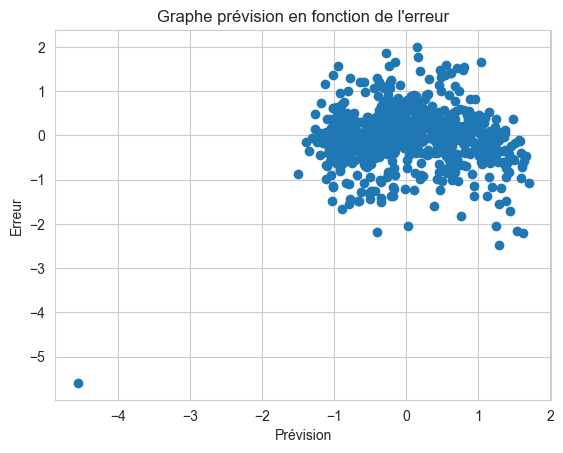

In [19]:
# Prévision en fonction de l'erreur
plt.figure()
plt.scatter(y_predi,erreur)
plt.xlabel('Prévision')
plt.ylabel('Erreur')
plt.title('Graphe prévision en fonction de l\'erreur')
plt.show()

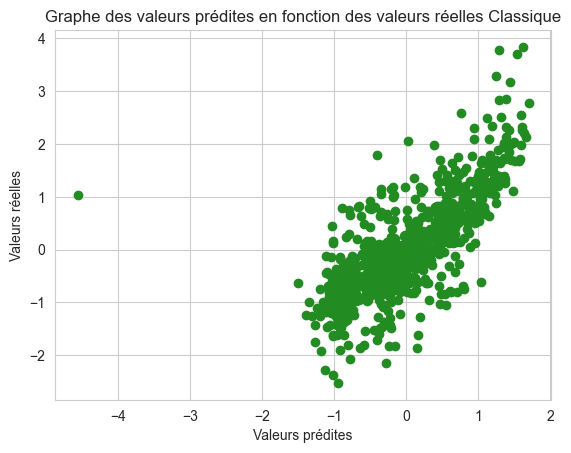

In [20]:
# Prévision en fonction des valeurs réelles
plt.figure()
plt.scatter(y_predi,y_train,c='forestgreen')

plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Graphe des valeurs prédites en fonction des valeurs réelles Classique')
plt.show()

#### Elastic Net

L'Elastic Net combine les avantages de Ridge et Lasso. Ridge permet d'éviter le surapprentissage, et Lasso peut engendrer un modèle instable (lorsqu'il doit choisir une variable et éliminer l'autre (qui sont corrélés), il peut choisir de manière aléatoire)

La capacité de sélection de variables du LASSO est conservée (coefficients nuls) : exclusion des variables non pertinentes • Groupe de variables prédictives corrélées, partage des poids (comme Ridge) et non plus sélection arbitraire.

Cela donne une solution plus stable que lasso, et dans lequel les variables corrélés pertinentes reçoivent un poids identique (Ridge)

In [21]:
# Instanciation et entrainement du modèle
training_start = time.perf_counter()
en_reg = ElasticNet()
parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.019, 0.01, 0.1, 1, 10, 100],
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}
en_reg.fit(X_train, y_train)
training_end = time.perf_counter()

# Recherche des paramètres et cross validation (5X) via GridSearchCV
gs_en = GridSearchCV(estimator = ElasticNet(),
                     param_grid = parameters,
                     scoring = 'neg_mean_squared_error',
                     cv=5,
                     verbose=0
                     )

gs_en.fit(X_train, y_train)


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e+02, tolerance: 6.157e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+02, tolerance: 5.407e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+02, tolerance: 5.713e+01 Linear regression models with null weig

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.019, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error')

##### Metrics

In [22]:
# Affichage des meilleurs paramètres afin d'optimiser le R2
score = make_scorer(r2_score)

print("Best parameter combination:", gs_en.best_params_, "\n")

# Affichage des scores grâce à la fonction "best_estimator"
h_model=gs_en.best_estimator_

print('r-squared score (training): {:.3f}'
      .format(h_model.score(X_train, y_train)))
print('r-squared score (testing): {:.3f}'
      .format(h_model.score(X_test, y_test)),"\n")

train_time=training_end-training_start
print('Time',train_time, "\n")

# Evaluation du modèle en fonction des données de test
pred_en = h_model.predict(X_test)
mse = mean_squared_error(y_test, pred_en)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


Best parameter combination: {'alpha': 0.019, 'l1_ratio': 0.1, 'tol': 0.1} 

r-squared score (training): 0.571
r-squared score (testing): 0.537 

Time 0.0025277920067310333 

MSE: 0.3081878219868508
RMSE: 0.5551466670951477


##### Feature Importance

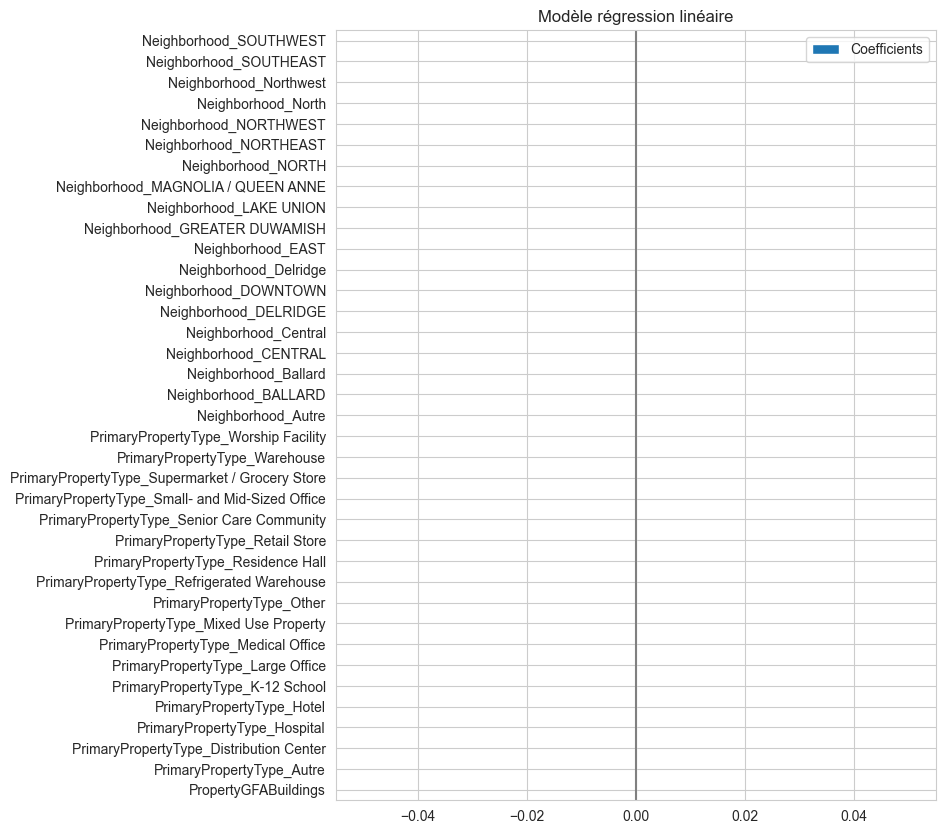

In [23]:
# Affichage des features
coefs = pd.DataFrame(
    en_reg.coef_,
    columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(10, 10))
plt.title('Modèle régression linéaire')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Nous rencontrons une première difficulté avec l'ElasticNet et la prise en compte des features.

##### Previsions en fonction de l'erreur / des valeurs réelles

In [24]:
y_predi = en_reg.predict(X_train) #prédiction
erreur=y_predi-y_train #erreur de prédiction

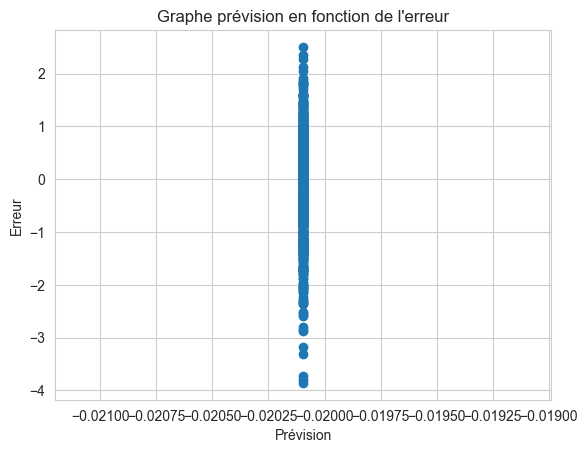

In [25]:
# Prévision en fonction de l'erreur
plt.figure()
plt.scatter(y_predi,erreur)
plt.xlabel('Prévision')
plt.ylabel('Erreur')
plt.title('Graphe prévision en fonction de l\'erreur')
plt.show()

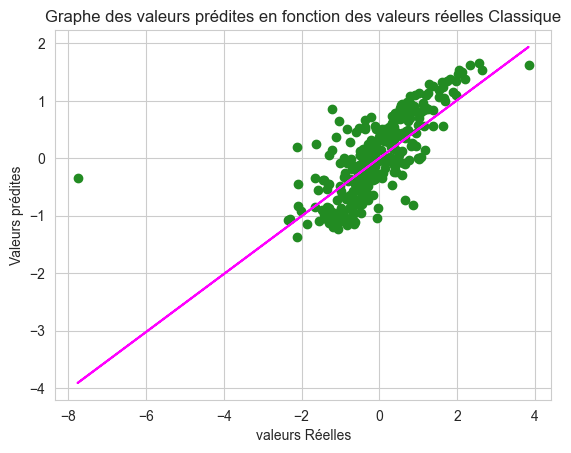

In [26]:
# Plot prédit vs actuel
plt.scatter(y_test, pred_en, c='forestgreen')
plt.xlabel('valeurs Réelles')
plt.ylabel('Valeurs prédites')
plt.title('Graphe des valeurs prédites en fonction des valeurs réelles Classique')
# Impression de la ligne de regression linéaire
z = np.polyfit(y_test, pred_en, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#### KNN

k-Nearest Neighbours (k-NN voire KNN ou méthode des k plus proches voisins) : k-NN est un algorithme standard de classification qui repose exclusivement sur le choix de la métrique de classification. Il est « non paramétrique » (seul k doit être fixé) et se base uniquement sur les données d’entraînement. Cet algorithme est utilisable en regression.



In [27]:
# Instanciation et entrainement du modèle
training_start = time.perf_counter()
param_grid = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': list(range(1, 36, 5))
}
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
training_end = time.perf_counter()

# Recherche des paramètres et cross validation(5X) via GridSearchCV
gs_knn = GridSearchCV(knn_reg,
                      param_grid,
                      cv=5,
                      scoring='neg_mean_squared_error',
                      verbose=1,
                      n_jobs=4
                      )

gs_knn
gs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=1)

##### Metrics

In [28]:
# Affichage des meilleurs paramètres afin d'optimiser le R2
score = make_scorer(r2_score)

print("Best parameter combination:", gs_knn.best_params_, "\n")

# Affichage des scores grâce à la fonction "best_estimator"
h_model=gs_knn.best_estimator_

print('r-squared score (training): {:.3f}'
      .format(h_model.score(X_train, y_train)))
print('r-squared score (testing): {:.3f}'
      .format(h_model.score(X_test, y_test)),"\n")

train_time=training_end-training_start
print('Time',train_time, "\n")

# Evaluation du modèle en fonction des données de test
pred_knn = h_model.predict(X_test)
mse = mean_squared_error(y_test, pred_knn)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


Best parameter combination: {'n_neighbors': 6, 'weights': 'uniform'} 

r-squared score (training): 0.697
r-squared score (testing): 0.487 

Time 0.001525208994280547 

MSE: 0.34101929025974353
RMSE: 0.5839685695820825


##### Previsions en fonction de l'erreur / des valeurs réelles

In [29]:
y_predi = knn_reg.predict(X_train) #prédiction
erreur=y_predi-y_train #erreur de prédiction

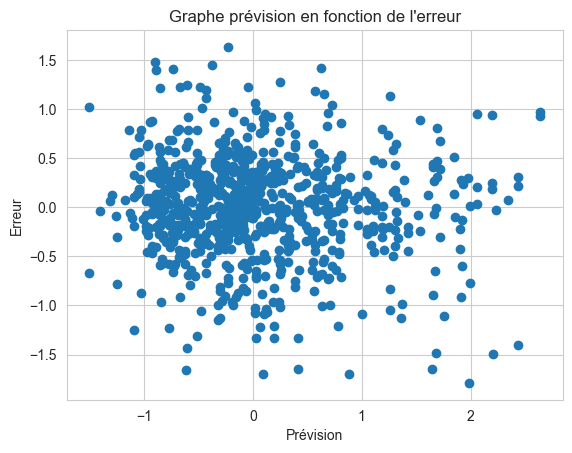

In [30]:
# Prévision en fonction de l'erreur
plt.figure()
plt.scatter(y_predi,erreur)
plt.xlabel('Prévision')
plt.ylabel('Erreur')
plt.title('Graphe prévision en fonction de l\'erreur')
plt.show()

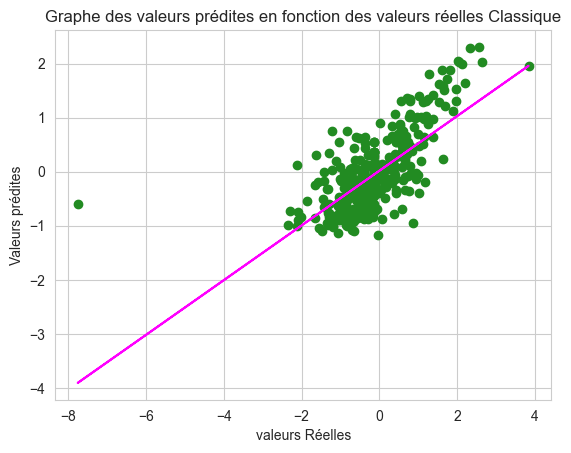

In [31]:
# graphe prédiction vs actuel
plt.scatter(y_test, pred_knn, c='forestgreen')
plt.xlabel('valeurs Réelles')
plt.ylabel('Valeurs prédites')
plt.title('Graphe des valeurs prédites en fonction des valeurs réelles Classique')
# Affiche la ligne de regression
z = np.polyfit(y_test, pred_knn, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#### SVR

L'analyse par machine vectorielle de support (SVM) est un outil d'apprentissage automatique populaire pour la classification et la régression. La régression SVM est considérée comme une technique non paramétrique car elle repose sur les fonctions du noyau.
Le SVM est un algorithme discriminant qui tente de trouver l'hyperplan optimal qui classe distinctement les points de données dans l'espace N-dimensionnel (N - le nombre de caractéristiques). Dans un espace bidimensionnel, un hyperplan est une ligne qui divise de manière optimale les points de données en deux classes différentes. Dans un espace de plus haute dimension, l'hyperplan aurait une forme différente plutôt qu'une ligne. Le SVM essayera de trouver l'hyperplan optimal.

La régression vectorielle de support (SVR) est assez différente des autres modèles de régression. Elle utilise l'algorithme Support Vector Machine (SVM, un algorithme de classification) pour prédire une variable continue. Alors que d'autres modèles de régression linéaire tentent de minimiser l'erreur entre la valeur prédite et la valeur réelle. La SVR tente d'adapter la meilleure ligne dans une valeur d'erreur prédéfinie ou seuil. La SVR essaie de classer toutes les lignes de prédiction en deux types, celles qui passent par la limite d'erreur (espace séparé par deux lignes parallèles) et celles qui n'y passent pas. Les lignes qui ne passent pas la limite d'erreur ne sont pas considérées comme la différence entre la valeur prédite et la valeur réelle a dépassé le seuil d'erreur, ε(epsilon). Les lignes qui passent sont considérées comme un vecteur de support potentiel pour prédire la valeur d'un inconnu.



In [32]:
# Instanciation et entrainement du modèle
training_start = time.perf_counter()
param_grid = {
    'gamma': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'epsilon': [0.001, 0.01, 0.1, 1],
    'C': [0.001, 0.01, 0.1, 1, 10]
}
svr_reg = SVR()
svr_reg.fit(X_train, y_train)
training_end = time.perf_counter()

# Recherche des paramètres et cross validation (5X) via GridSearchCV
gs_svm = GridSearchCV(svr_reg,
                      param_grid,
                      cv=5,
                      scoring='neg_mean_squared_error',
                      verbose=1,
                      n_jobs=4
                      )

gs_svm
gs_svm.fit(X_train, y_train)


Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             scoring='neg_mean_squared_error', verbose=1)

##### Metrics

In [33]:
# Affichage des meilleurs paramètres afin d'optimiser le R2
score = make_scorer(r2_score)

print("Best parameter combination:", gs_svm.best_params_, "\n")

# Affichage des scores grâce à la fonction "best_estimator"
h_model=gs_svm.best_estimator_
print('r-squared score (training): {:.3f}'
      .format(h_model.score(X_train, y_train)))
print('r-squared score (testing): {:.3f}'
      .format(h_model.score(X_test, y_test)),"\n")

train_time=training_end-training_start
print('Time',train_time, "\n")

# Evaluation du modèle en fonction des données de test
pred_svm = h_model.predict(X_test)
mse = mean_squared_error(y_test, pred_svm)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Best parameter combination: {'C': 10, 'epsilon': 0.1, 'gamma': 0.01} 

r-squared score (training): 0.643
r-squared score (testing): 0.565 

Time 0.044165790983242914 

MSE: 0.28953470103241824
RMSE: 0.5380842880371236


##### Previsions en fonction de l'erreur / des valeurs réelles

In [34]:
y_predi = svr_reg.predict(X_train)  #prédiction
erreur = y_predi - y_train  #erreur de prédiction

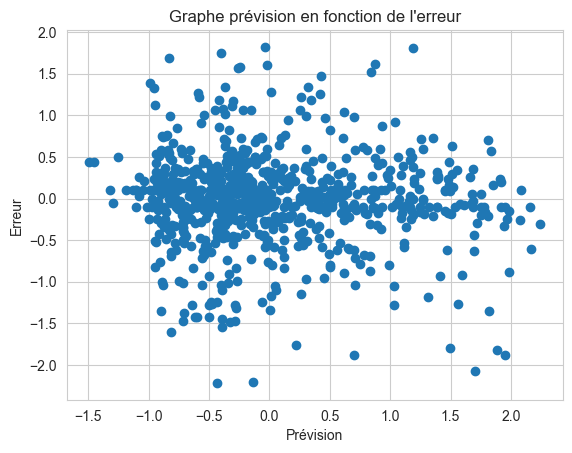

In [35]:
plt.figure()
plt.scatter(y_predi, erreur)
plt.xlabel('Prévision')
plt.ylabel('Erreur')
plt.title('Graphe prévision en fonction de l\'erreur')
plt.show()

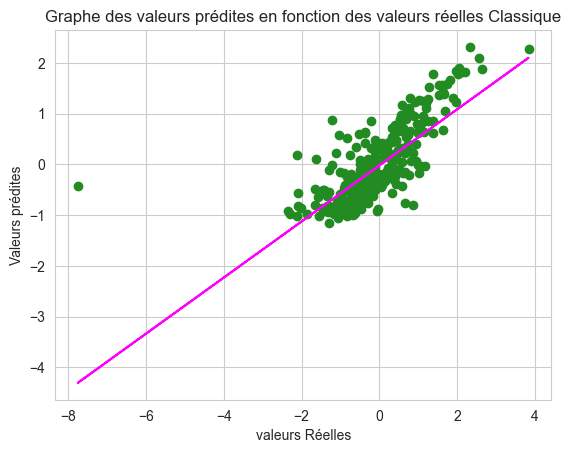

In [36]:
# graphe prédiction vs actuel
plt.scatter(y_test, pred_svm, c='forestgreen')
plt.xlabel('valeurs Réelles')
plt.ylabel('Valeurs prédites')
plt.title('Graphe des valeurs prédites en fonction des valeurs réelles Classique')
# Affiche la ligne de regression
z = np.polyfit(y_test, pred_svm, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()

#### Random Forest Regressor

La régression Random Forest est un algorithme d'apprentissage supervisé qui utilise une méthode d'apprentissage d'ensemble pour larégression. La méthode d'apprentissage d'ensemble est une technique qui combine les prédictions de plusieurs algorithme d'apprentissage automatique pour faire une prédiction plus précise qu'un seul modèle.

Le Random Forest Regressor est puissant et précis. Il fonctionne généralement très bien sur de nombreux problèmes, y compris les caractéristiques avec des relations non linéaires. Les inconvénients, cependant, comprennent ce qui suit : il n'y a pas d'interprétabilité, un overfiting peut facilement se produire, nous devons choisir le nombre d'arbres à inclure dans le modèle.

In [37]:
# Instanciation et entrainement du modèle
training_start = time.perf_counter()
param_grid = {
    "n_estimators"      : [100,200,500],
    "max_features"      : ["auto", "sqrt", "log2"],
    "min_samples_split" : [2,4,8],
    "bootstrap": [True, False],
}
rfr_reg = RandomForestRegressor(max_leaf_nodes=200, random_state=42)
rfr_reg.fit(X_train, y_train)
training_end = time.perf_counter()

# Recherche des paramètres et cross validation (5X) via GridSearchCV
gs_rfr = GridSearchCV(rfr_reg,
                      param_grid,
                      scoring = 'neg_mean_squared_error',
                      n_jobs=-1,
                      cv=5
                      )

gs_rfr
gs_rfr.fit(X_train, y_train)

/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly s

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_leaf_nodes=200,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error')

##### Metrics

In [38]:
# Affichage des meilleurs paramètres afin d'optimiser le R2
score = make_scorer(r2_score)

print("Best parameter combination:", gs_rfr.best_params_, "\n")

# Affichage des scores grâce à la fonction "best_estimator"
h_model=gs_rfr.best_estimator_

print('r-squared score (training): {:.3f}'
      .format(h_model.score(X_train, y_train)))
print('r-squared score (testing): {:.3f}'
      .format(h_model.score(X_test, y_test)),"\n")

train_time=training_end-training_start
print('Time',train_time, "\n")

# Evaluation du modèle en fonction des données de test
pred_rfr = h_model.predict(X_test)
mse = mean_squared_error(y_test, pred_rfr)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


Best parameter combination: {'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 100} 

r-squared score (training): 0.849
r-squared score (testing): 0.538 

Time 0.20489999998244457 

MSE: 0.3073643624405285
RMSE: 0.5544045115622063


##### Feature Importance

In [39]:
y_predi = rfr_reg.predict(X_train) #prédiction
erreur=y_predi-y_train #erreur de prédiction

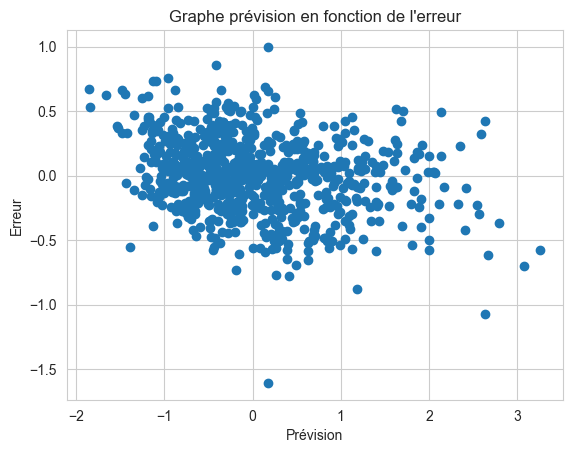

In [40]:
plt.figure()
plt.scatter(y_predi,erreur)
plt.xlabel('Prévision')
plt.ylabel('Erreur')
plt.title('Graphe prévision en fonction de l\'erreur')
plt.show()

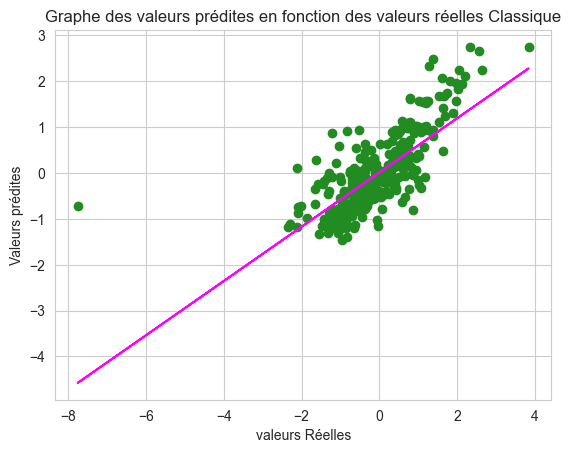

In [41]:
# graphe prédiction vs actuel
plt.scatter(y_test, pred_rfr, c='forestgreen')
plt.xlabel('valeurs Réelles')
plt.ylabel('Valeurs prédites')
plt.title('Graphe des valeurs prédites en fonction des valeurs réelles Classique')
# Affiche la ligne de regression
z = np.polyfit(y_test, pred_rfr, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()

##### Previsions en fonction de l'erreur / des valeurs réelles

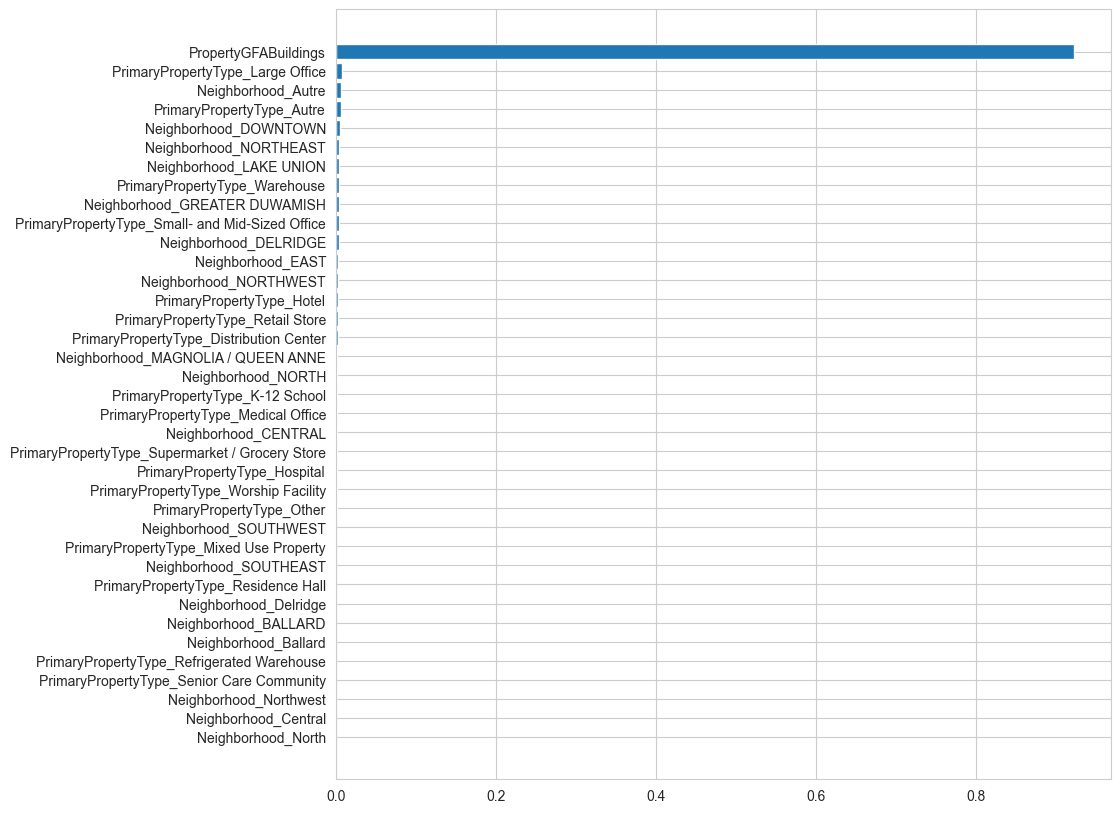

In [42]:
importances = rfr_reg.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

#### XGBOOST

In [43]:
# Instanciation et entrainement du modèle
param_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

boost_reg = XGBRegressor()
boost_reg.fit(X_train, y_train)
p_boost = boost_reg.predict(X_train)

# Recherche des paramètres et cross validation (5X) via GridSearchCV
gs_boost = GridSearchCV(boost_reg, param_grid,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1, cv=5)
gs_boost.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

##### Metrics

In [44]:
# Affichage des meilleurs paramètres afin d'optimiser le R2
score = make_scorer(r2_score)

print("Best parameter combination:", gs_boost.best_params_, "\n")

# Affichage des scores grâce à la fonction "best_estimator"
h_model=gs_boost.best_estimator_

print('r-squared score (training): {:.3f}'
      .format(boost_reg.score(X_train, y_train)))
print('r-squared score (testing): {:.3f}'
      .format(boost_reg.score(X_test, y_test)))

train_time=training_end-training_start
print('Time',train_time, "\n")

# Evaluation du modèle en fonction des données de test
pred_boost = h_model.predict(X_test)
mse = mean_squared_error(y_test, pred_boost)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


Best parameter combination: {'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6} 

r-squared score (training): 0.947
r-squared score (testing): 0.506
Time 0.20489999998244457 

MSE: 0.2942988077080433
RMSE: 0.5424931407013763


In [45]:
y_predi_xgb = boost_reg.predict(X_train) #prédiction
erreur=y_predi-y_train #erreur de prédiction

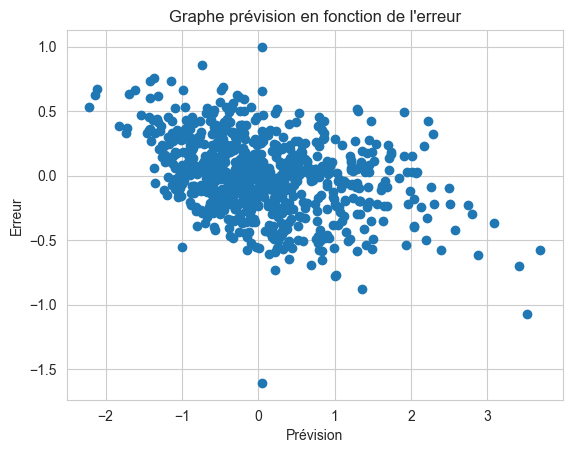

In [46]:
plt.figure()
plt.scatter(y_predi_xgb,erreur)
plt.xlabel('Prévision')
plt.ylabel('Erreur')
plt.title('Graphe prévision en fonction de l\'erreur')
plt.show()

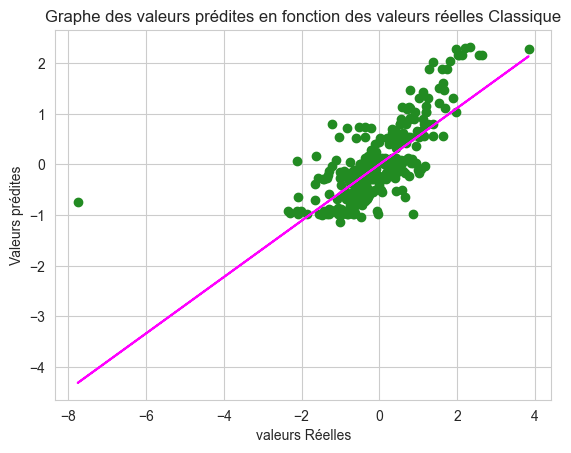

In [47]:
# graphe prédiction vs actuel
plt.scatter(y_test, pred_boost, c='forestgreen')
plt.xlabel('valeurs Réelles')
plt.ylabel('Valeurs prédites')
plt.title('Graphe des valeurs prédites en fonction des valeurs réelles Classique')
# Affiche la ligne de regression
z = np.polyfit(y_test, pred_boost, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()

##### Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

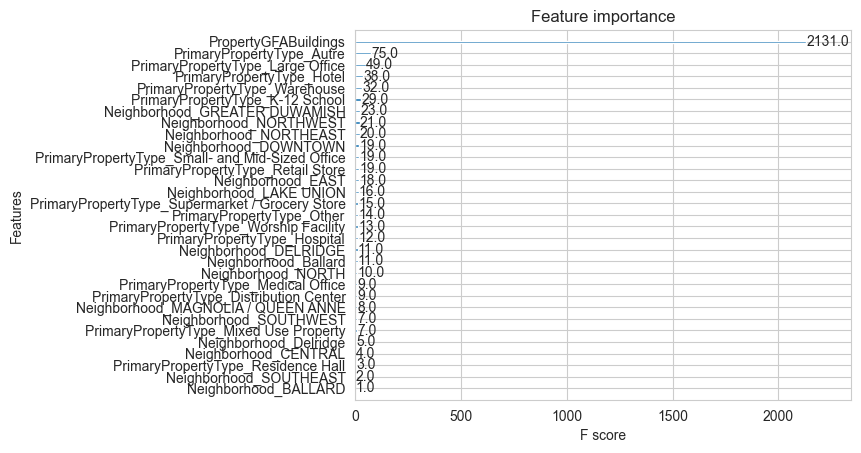

In [48]:
xgb.plot_importance(boost_reg)

## Comparaison des modèles selon les datasets

In [49]:
# Sets disponibles
sets = {'X1', 'X2', 'X3'}

In [50]:
# Définition des modèles
models = {'OLS': LinearRegression(),
          'ElasticNet': ElasticNet(),
          'KNN': KNeighborsRegressor(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(max_leaf_nodes=200, random_state=42),
          'XGBR': XGBRegressor(n_estimators=100)
          }

### Dataframe X1

In [51]:
# Choix du dataset
X = scaling(X1)

#Creation des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [52]:
# Affichage des résultats
resultats_X1 = test( models, X_train, X_test, y_train, y_test)
display(resultats_X1.reset_index())

,index,R2 Score,MAE,MSE,RMSE,Erreur moyenne
0,OLS,0.53776,0.28930,0.30741,0.55445,0.28930
1,ElasticNet,-0.01644,0.52691,0.67599,0.82219,0.52691
2,KNN,0.47805,0.30108,0.34712,0.58917,0.30108
3,SVR,0.56053,0.28998,0.29227,0.54062,0.28998
4,Random Forest,0.50906,0.28753,0.32650,0.57141,0.28753
5,XGBR,0.49142,0.31201,0.33824,0.58158,0.31201


### Dataframe X2

In [53]:
# Choix du dataset
X = scaling(X2)
#Creation des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [54]:
# Affichage des résultats
resultats_X2 = test(models, X_train, X_test, y_train, y_test)
display(resultats_X2.reset_index())

,index,R2 Score,MAE,MSE,RMSE,Erreur moyenne
0,OLS,0.53852,0.28852,0.30691,0.55400,0.28852
1,ElasticNet,-0.01644,0.52691,0.67599,0.82219,0.52691
2,KNN,0.47984,0.29978,0.34594,0.58816,0.29978
3,SVR,0.56033,0.28038,0.29241,0.54075,0.28038
4,Random Forest,0.50823,0.28831,0.32705,0.57189,0.28831
5,XGBR,0.48069,0.31315,0.34537,0.58768,0.31315


### Dataframe X3

In [55]:
# Choix du dataset
X = scaling(X3)

#Creation des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [56]:
# Affichage des résultats
resultats_X3 = test( models, X_train, X_test, y_train, y_test)
display(resultats_X3.reset_index())

,index,R2 Score,MAE,MSE,RMSE,Erreur moyenne
0,OLS,0.54128,0.28987,0.30508,0.55234,0.28987
1,ElasticNet,-0.01644,0.52691,0.67599,0.82219,0.52691
2,KNN,0.52120,0.28740,0.31843,0.56429,0.28740
3,SVR,0.55797,0.27733,0.29397,0.54219,0.27733
4,Random Forest,0.55286,0.26627,0.29737,0.54532,0.26627
5,XGBR,0.47879,0.29804,0.34663,0.58875,0.29804


### Classement des modèles par le R2

In [57]:
# Création du df de transition 1/2
res_conc1 =(pd.concat([resultats_X1, resultats_X2],
                  axis = 0))

In [58]:
# Création du df de transition 2/2
resultats_conc_final =(pd.concat([res_conc1, resultats_X3],
                  axis = 0))
resultats_conc_final = resultats_conc_final.reset_index()

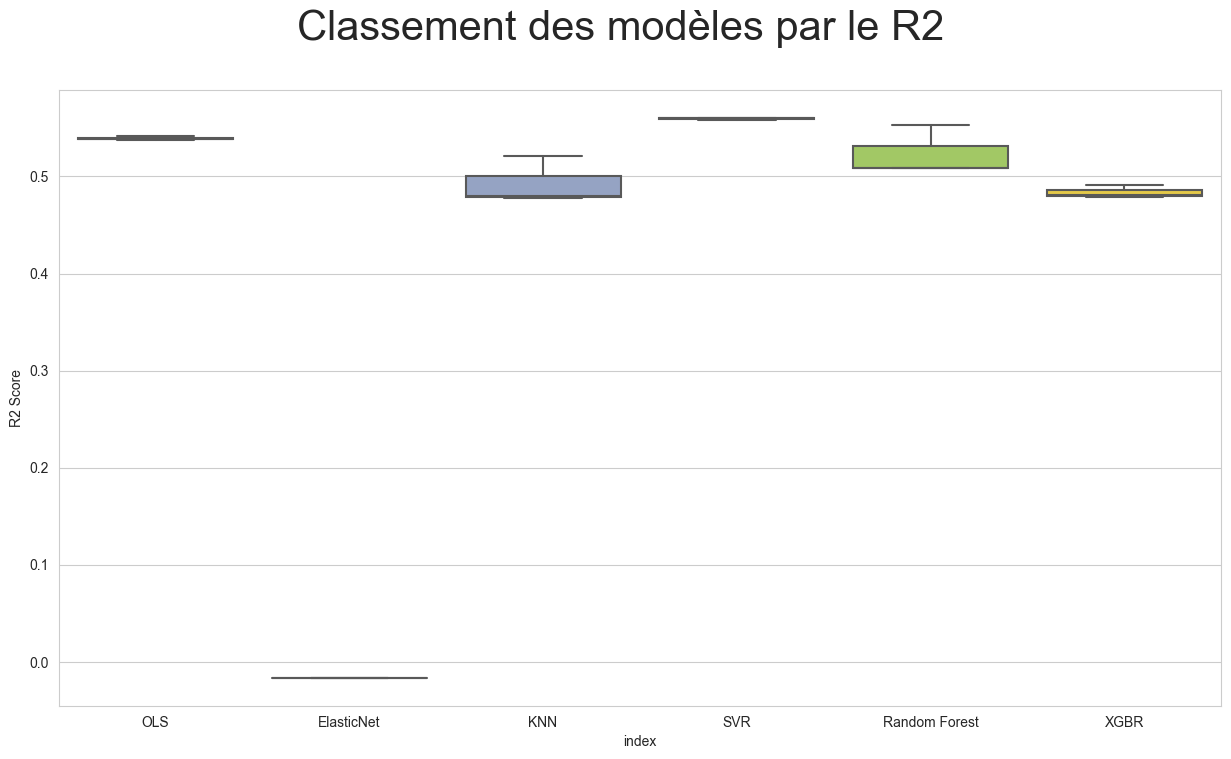

In [59]:
# Création de la boxplot
fig = plt.figure(figsize=(15,8))
fig.suptitle('Classement des modèles par le R2', fontsize=30)

chart = sns.boxplot(
    data=resultats_conc_final,
    x='index',
    y='R2 Score',
    palette='Set2'
)

Les 3 modèles émergeants sur les données de consommation sont le :
Le SVR
Le Random Forest
Le XgBoost


### Choix provisoire des modèles

#### Affichage des données R2 et MAE (Erreur Moyenne)

In [60]:
data_choix = resultats_conc_final.reset_index()

In [61]:
data_choix = data_choix.drop(['level_0','MAE', 'MSE', 'RMSE'], 1)


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [62]:
display(data_choix.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
index,OLS,ElasticNet,KNN,SVR,Random Forest,XGBR,OLS,ElasticNet,KNN,SVR,Random Forest,XGBR,OLS,ElasticNet,KNN,SVR,Random Forest,XGBR
R2 Score,0.53776,-0.01644,0.47805,0.56053,0.50906,0.49142,0.53852,-0.01644,0.47984,0.56033,0.50823,0.48069,0.54128,-0.01644,0.5212,0.55797,0.55286,0.47879
Erreur moyenne,0.2893,0.52691,0.30108,0.28998,0.28753,0.31201,0.28852,0.52691,0.29978,0.28038,0.28831,0.31315,0.28987,0.52691,0.2874,0.27733,0.26627,0.29804


### Metrics des modèles

'Metrics du jeu de données X1'

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


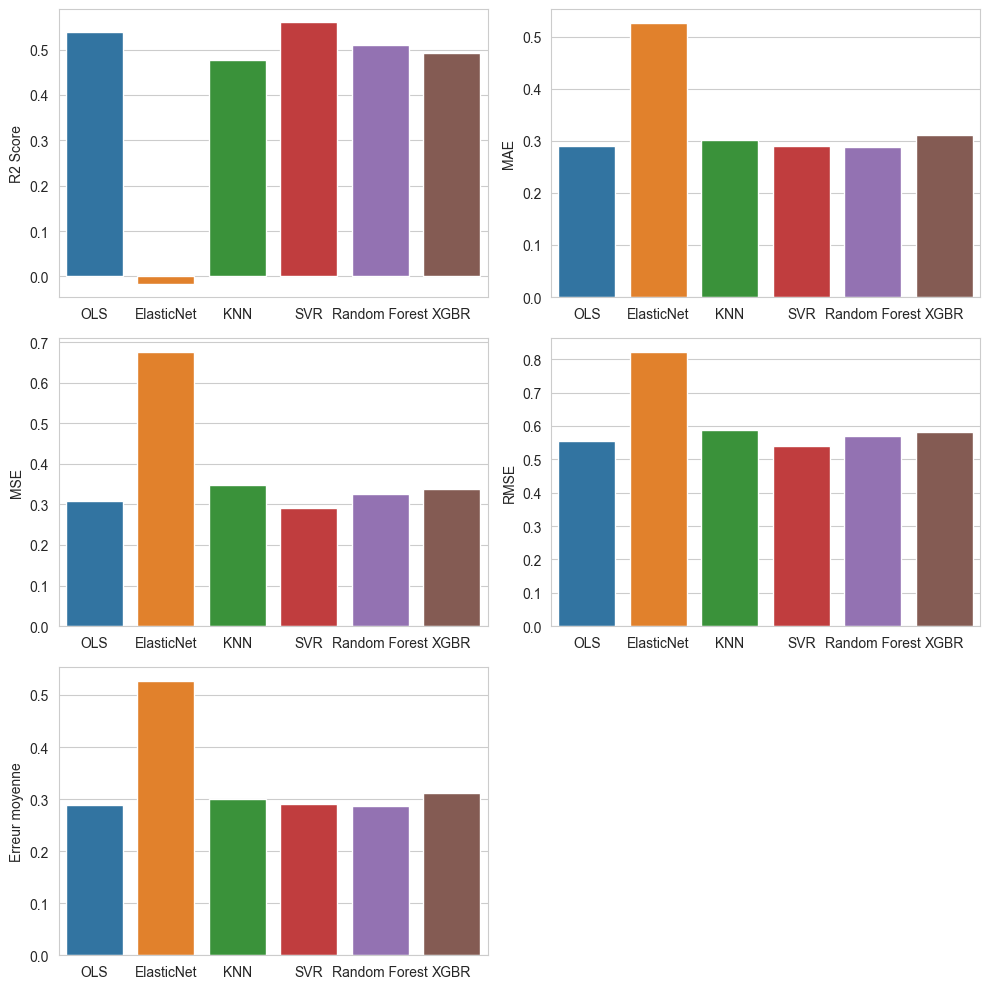

'Metrics du jeu de données X2'

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


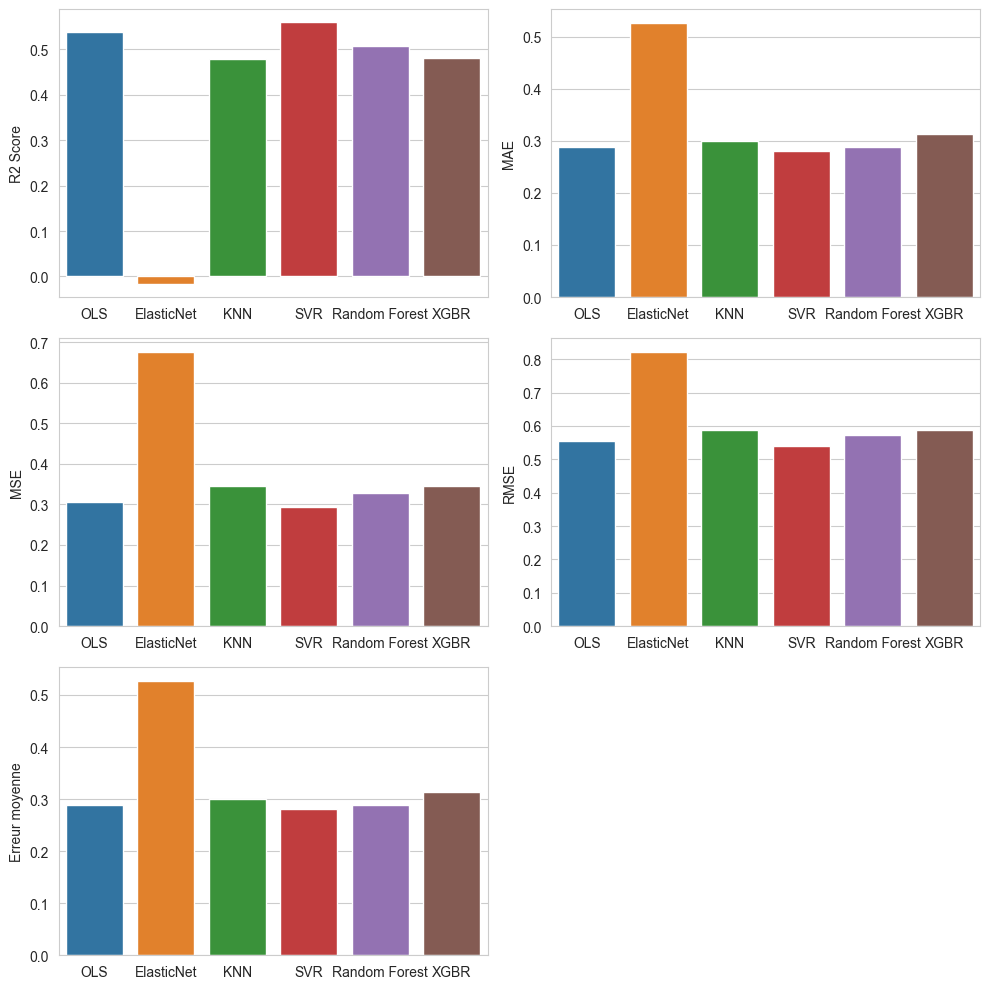

'Metrics du jeu de données X3'

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


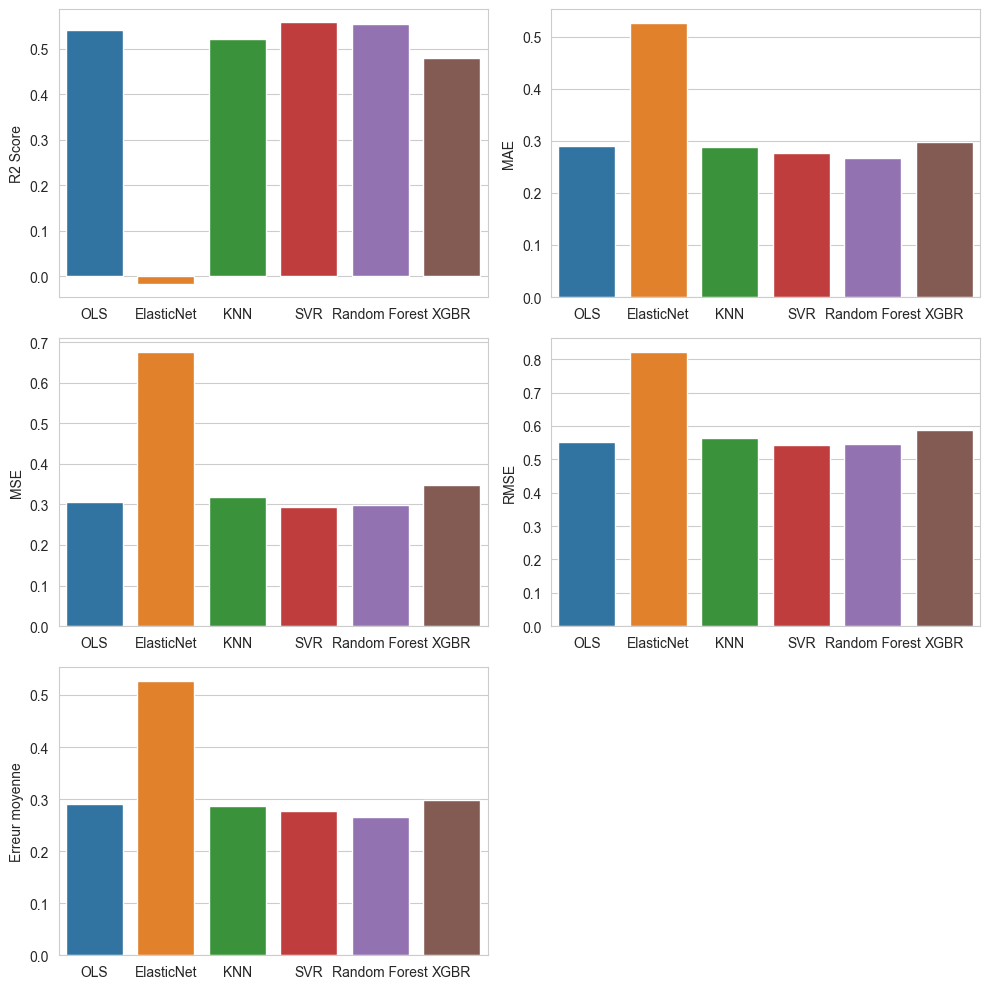

In [63]:
# on affiche les résultats optimum sur les jeux de test
display('Metrics du jeu de données X1')
models_viz(resultats_X1)

display('Metrics du jeu de données X2')
models_viz(resultats_X2)

display('Metrics du jeu de données X3')
models_viz(resultats_X3)

Le modèle SVR a une prédominance du R2 sur les 2 premiers datasets. Le Random Forest tend à accroître son efficacité lorsque les features sont plus nombreuses. Cela se vérifie aussi bien au niveau du R2 que du MSE et de l’erreur moyenne.

Le modèle ElasticNet est inopérant dans notre étude.

## Test des modèles non optimisé avec l'ENERGYSTAR Score

### Préparation des données

In [64]:
# scaling du jeu de données
scaling (X4)

,NumberofBuildings,PropertyGFABuildings,YearBuilt,ENERGYSTARScore,PrimaryPropertyType_Autre,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_Autre,Neighborhood_BALLARD,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,1.0,0.55599,-1.14199,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.55680,1.06722,60.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2.04786,0.07960,61.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.14396,-1.16704,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.80412,0.46072,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,1.0,-0.07790,0.01326,98.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1688,1.0,-0.07790,0.01326,72.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1689,1.0,-0.07790,0.01326,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1690,1.0,-0.07790,0.01326,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Création des jeux de données Entrainement / test

In [65]:
#Création des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [66]:
# Définition des modèles
models = {'OLS': LinearRegression(),
          'ElasticNet': ElasticNet(),
          'KNN': KNeighborsRegressor(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(),
          'XGBR': XGBRegressor()
          }

In [67]:
# on affiche les résultats sur les jeux de test
resultats_ess = test( models, X_train, X_test, y_train, y_test)
display(resultats_ess)

,R2 Score,MAE,MSE,RMSE,Erreur moyenne
OLS,0.54128,0.28987,0.30508,0.55234,0.28987
ElasticNet,-0.01644,0.52691,0.67599,0.82219,0.52691
KNN,0.52120,0.28740,0.31843,0.56429,0.28740
SVR,0.55797,0.27733,0.29397,0.54219,0.27733
Random Forest,0.55518,0.26463,0.29583,0.54390,0.26463
XGBR,0.47879,0.29804,0.34663,0.58875,0.29804


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


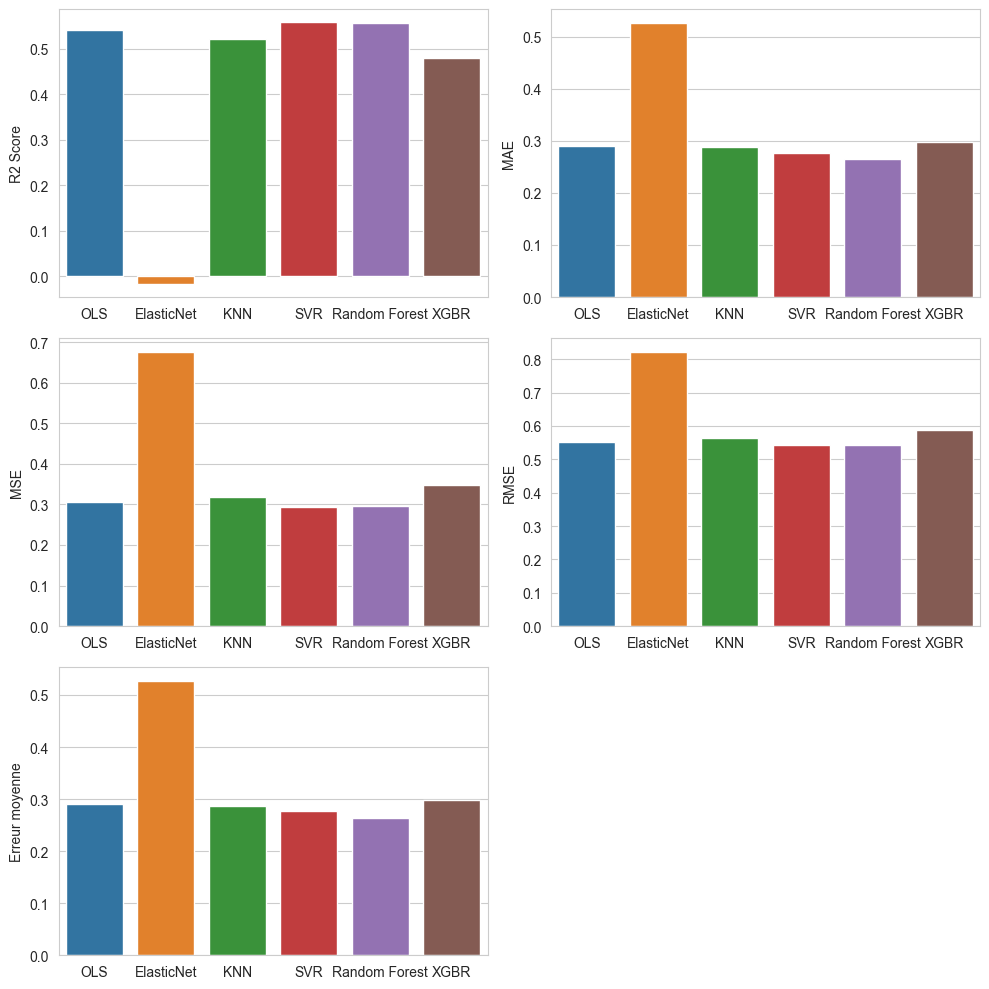

In [68]:
models_viz(resultats_ess)

Les 3 modèles émergeants sur les données de consommation sont le :
Le SVR
Le Random Forest
Le KNN

En revanche le modèle Random Forest, à une erreur moyenne (MAE) plus faible que les autres modèles.


## Test des modèles avec optimisation des Hyperparamètres

#### Recherche des hyperparametres X4

In [69]:
# hyperparametres ElasticNet
param_grid = {'tol' : [0.1,0.01,0.001,0.0001],"alpha": [0.0001, 0.019, 0.01, 0.1, 1, 10, 100],"l1_ratio": np.arange(0.0, 1.0, 0.1)}
en_x4 = ElasticNet()
gs_en_x4 = GridSearchCV(en_x4,param_grid,cv=5,scoring='neg_mean_squared_error',verbose=1,n_jobs=4)
gs_en_x4.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.104e+02, tolerance: 6.289e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.347e+02, tolerance: 6.157e+01 Linear regression models with null weight for the l1 regularization term are more efficien

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=4,
             param_grid={'alpha': [0.0001, 0.019, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error', verbose=1)

In [70]:
#hyperparametres knn
param_grid = {'weights': ['uniform', 'distance'],'n_neighbors': list(range(1, 36, 5))}
knn_x4 = KNeighborsRegressor()
gs_knn_x4 = GridSearchCV(knn_x4,param_grid,cv=5,scoring='neg_mean_squared_error',verbose=1,n_jobs=4)
gs_knn_x4.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=1)

In [71]:
#hyperparametres svr
param_grid = {'gamma': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],'epsilon': [0.001, 0.01, 0.1, 1], 'C': [0.001, 0.01, 0.1, 1, 10]}
svr_x4 = SVR()
gs_svr_x4 = GridSearchCV(svr_x4,param_grid,cv=5,scoring='neg_mean_squared_error',verbose=1,n_jobs=4)
gs_svr_x4.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             scoring='neg_mean_squared_error', verbose=1)

In [72]:
#hyperparametres RandomForest regressor
param_grid = {"n_estimators":[100,200,500],"max_features":["auto", "sqrt", "log2"],"min_samples_split":[2,4,8],"bootstrap":[True, False],}
rfr_x4 = RandomForestRegressor()
gs_rfr_x4 = GridSearchCV(rfr_x4,param_grid,cv=5,scoring='neg_mean_squared_error',verbose=1,n_jobs=4)
gs_rfr_x4.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly s

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [73]:
#Hyperparametres XGBoost
param_grid = {'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],'subsample': [0.6, 0.8, 1.0],'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 4, 5]}
xgb_x4 = XGBRegressor()
gs_xgb_x4 = GridSearchCV(xgb_x4,param_grid,cv=5,scoring='neg_mean_squared_error',verbose=1,n_jobs=4)
gs_xgb_x4.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [74]:
print('Hyperparamètres ElastiqueNet :', gs_en_x4.best_params_)
print('Hyperparamètres KNN :', gs_knn_x4.best_params_)
print('Hyperparamètres SVR :', gs_svr_x4.best_params_)
print('Hyperparamètres Random Forest Regressor :', gs_rfr_x4.best_params_)
print('Hyperparamètres XGBoost :', gs_xgb_x4.best_params_)

Hyperparamètres ElastiqueNet : {'alpha': 0.019, 'l1_ratio': 0.0, 'tol': 0.1}
Hyperparamètres KNN : {'n_neighbors': 11, 'weights': 'uniform'}
Hyperparamètres SVR : {'C': 1, 'epsilon': 0.001, 'gamma': 0.1}
Hyperparamètres Random Forest Regressor : {'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 500}
Hyperparamètres XGBoost : {'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}


### Catalogues des hyper Paramètres

In [75]:
# Définition des modèles
models_opti = {'OLS': LinearRegression(),
                    'ElasticNet': ElasticNet(alpha=0.019, l1_ratio=0.1, tol=0.1),
                    'KNN': KNeighborsRegressor(n_neighbors=6, weights='uniform'),
                    'SVR': SVR(C=10, epsilon=0.1, gamma=0.01) ,
                    'Random Forest': RandomForestRegressor(bootstrap=True, max_features='auto', min_samples_split=8, n_estimators = 100),
                    'XGBR': XGBRegressor(colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.6)
                  }

models_opti_X4 = {'OLS': LinearRegression(),
                    'ElasticNet': ElasticNet(alpha=0.019, l1_ratio=0.0, tol=0.1),
                    'KNN': KNeighborsRegressor(n_neighbors=11, weights='uniform'),
                    'SVR': SVR(C=1, epsilon=0.001, gamma=0.1) ,
                    'Random Forest': RandomForestRegressor(bootstrap=True, max_features='auto', min_samples_split=8, n_estimators = 500),
                    'XGBR': XGBRegressor(colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0)
                }

## Modèles optimisés

### Dataframe X1

In [76]:
X = scaling(X1)

#Creation des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [77]:
resultats_X1 = test( models_opti, X_train, X_test, y_train, y_test)
display(resultats_X1.reset_index())

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


,index,R2 Score,MAE,MSE,RMSE,Erreur moyenne
0,OLS,0.53776,0.28930,0.30741,0.55445,0.28930
1,ElasticNet,0.53543,0.28516,0.30896,0.55585,0.28516
2,KNN,0.49483,0.29377,0.33597,0.57963,0.29377
3,SVR,0.56329,0.27708,0.29044,0.53892,0.27708
4,Random Forest,0.53137,0.27891,0.31166,0.55827,0.27891
5,XGBR,0.54382,0.27705,0.30338,0.55080,0.27705


### Dataframe X2

In [78]:
X = scaling(X2)

#Creation des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [79]:
resultats_X2 = test( models_opti, X_train, X_test, y_train, y_test)
display(resultats_X2.reset_index())

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


,index,R2 Score,MAE,MSE,RMSE,Erreur moyenne
0,OLS,0.53852,0.28852,0.30691,0.55400,0.28852
1,ElasticNet,0.53508,0.28628,0.30920,0.55605,0.28628
2,KNN,0.49635,0.29326,0.33496,0.57875,0.29326
3,SVR,0.56336,0.27616,0.29039,0.53888,0.27616
4,Random Forest,0.52780,0.27973,0.31404,0.56039,0.27973
5,XGBR,0.54382,0.27705,0.30338,0.55080,0.27705


### Dataframe X3

In [80]:
X = scaling(X3)

#Creation des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [81]:
resultats_X3 = test( models_opti, X_train, X_test, y_train, y_test)
display(resultats_X3.reset_index())

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


,index,R2 Score,MAE,MSE,RMSE,Erreur moyenne
0,OLS,0.54128,0.28987,0.30508,0.55234,0.28987
1,ElasticNet,0.53933,0.28005,0.30637,0.55351,0.28005
2,KNN,0.52556,0.28587,0.31553,0.56172,0.28587
3,SVR,0.56740,0.26830,0.28770,0.53638,0.26830
4,Random Forest,0.56042,0.26172,0.29234,0.54069,0.26172
5,XGBR,0.54548,0.28050,0.30228,0.54980,0.28050


In [82]:
# Création du df de transition 1/2
res_conc1 =(pd.concat([resultats_X1, resultats_X2],
                      axis = 0))

In [83]:
# Création du df de transition 2/2
resultats_conc_final =(pd.concat([res_conc1, resultats_X3],
                                 axis = 0))
resultats_conc_final = resultats_conc_final.reset_index()

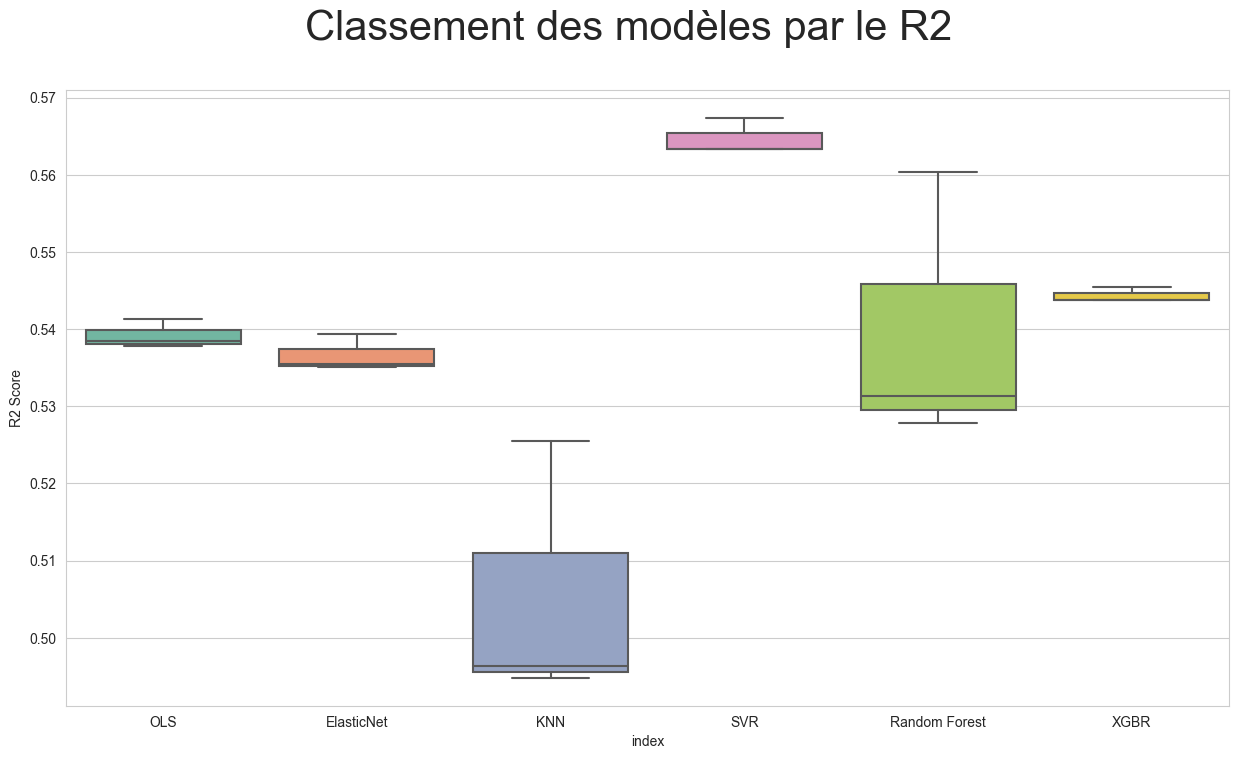

In [84]:
# Création de la boxplot
fig = plt.figure(figsize=(15,8))
fig.suptitle('Classement des modèles par le R2', fontsize=30)

chart = sns.boxplot(
    data=resultats_conc_final,
    x='index',
    y='R2 Score',
    palette='Set2'
)

Les datasets émergeants lors des observations précédentes sont identiques. Le SVR semble toujours être le plus efficace.

L’erreur moyennes est en revanche plus faible avec le Random Forest


### Dataset ENERGYSTARScore optimisé

In [85]:
X = scaling(X4)

In [86]:
#Creation des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [87]:
resultats_optim_ess = test(models_opti_X4, X_train, X_test, y_train, y_test)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+02, tolerance: 7.401e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


In [88]:
# on affiche les résultats optimum sur les jeux de test
display(resultats_optim_ess)

,R2 Score,MAE,MSE,RMSE,Erreur moyenne
OLS,0.54106,0.28999,0.30522,0.55246,0.28999
ElasticNet,0.53969,0.28380,0.30613,0.55329,0.28380
KNN,0.42278,0.33948,0.38388,0.61958,0.33948
SVR,0.50492,0.29075,0.32926,0.57381,0.29075
Random Forest,0.56192,0.25965,0.29135,0.53977,0.25965
XGBR,0.56781,0.25469,0.28743,0.53613,0.25469


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


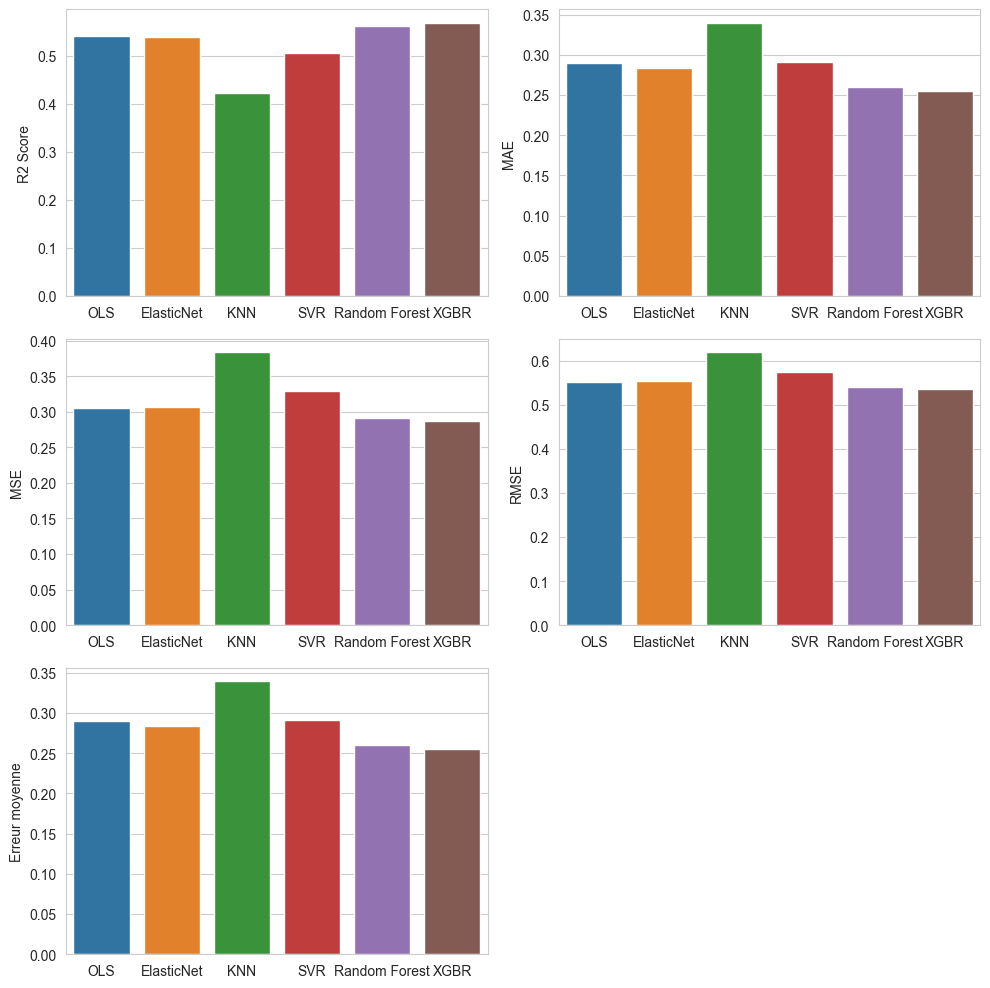

In [89]:
models_viz(resultats_optim_ess)

## Test du Random Forest et du XGBoost avec l'ENERGYSTAR Score


## Préparation des jeux données

In [108]:
X = scaling(X4)

In [109]:
#Creation des jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [110]:
#### Random Forest Regressor optimisé
rfr_reg = RandomForestRegressor(bootstrap=True, max_features='auto', min_samples_split=8, n_estimators = 500)
rfr_reg.fit(X_train, y_train)

# Affichage des résultats
resultats_rfr_reg = test(models_opti_X4, X_train, X_test, y_train, y_test)
display(resultats_rfr_reg.reset_index())


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+02, tolerance: 7.401e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


,index,R2 Score,MAE,MSE,RMSE,Erreur moyenne
0,OLS,0.54106,0.28999,0.30522,0.55246,0.28999
1,ElasticNet,0.53969,0.28380,0.30613,0.55329,0.28380
2,KNN,0.42278,0.33948,0.38388,0.61958,0.33948
3,SVR,0.50492,0.29075,0.32926,0.57381,0.29075
4,Random Forest,0.56481,0.25885,0.28943,0.53798,0.25885
5,XGBR,0.56781,0.25469,0.28743,0.53613,0.25469


In [ ]:
models_viz(resultats_rfr_reg)

In [ ]:
explainer = shap.TreeExplainer(rfr_reg)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


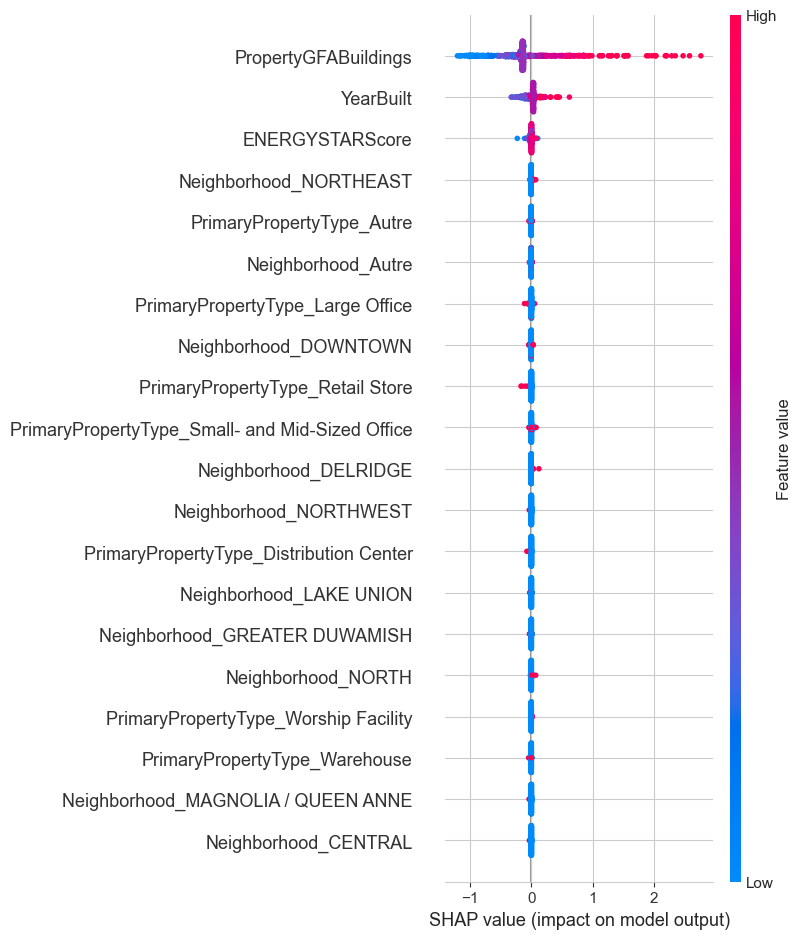

In [96]:
shap.summary_plot(shap_values, X_test)

In [97]:
#### XGB Regressor
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

# Affichage des résultats
resultats_xgb_reg = test(models_opti_X4, X_train, X_test, y_train, y_test)
display(resultats_xgb_reg.reset_index())


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+02, tolerance: 7.401e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


,index,R2 Score,MAE,MSE,RMSE,Erreur moyenne
0,OLS,0.54106,0.28999,0.30522,0.55246,0.28999
1,ElasticNet,0.53969,0.28380,0.30613,0.55329,0.28380
2,KNN,0.42278,0.33948,0.38388,0.61958,0.33948
3,SVR,0.50492,0.29075,0.32926,0.57381,0.29075
4,Random Forest,0.56204,0.26061,0.29127,0.53969,0.26061
5,XGBR,0.56781,0.25469,0.28743,0.53613,0.25469


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


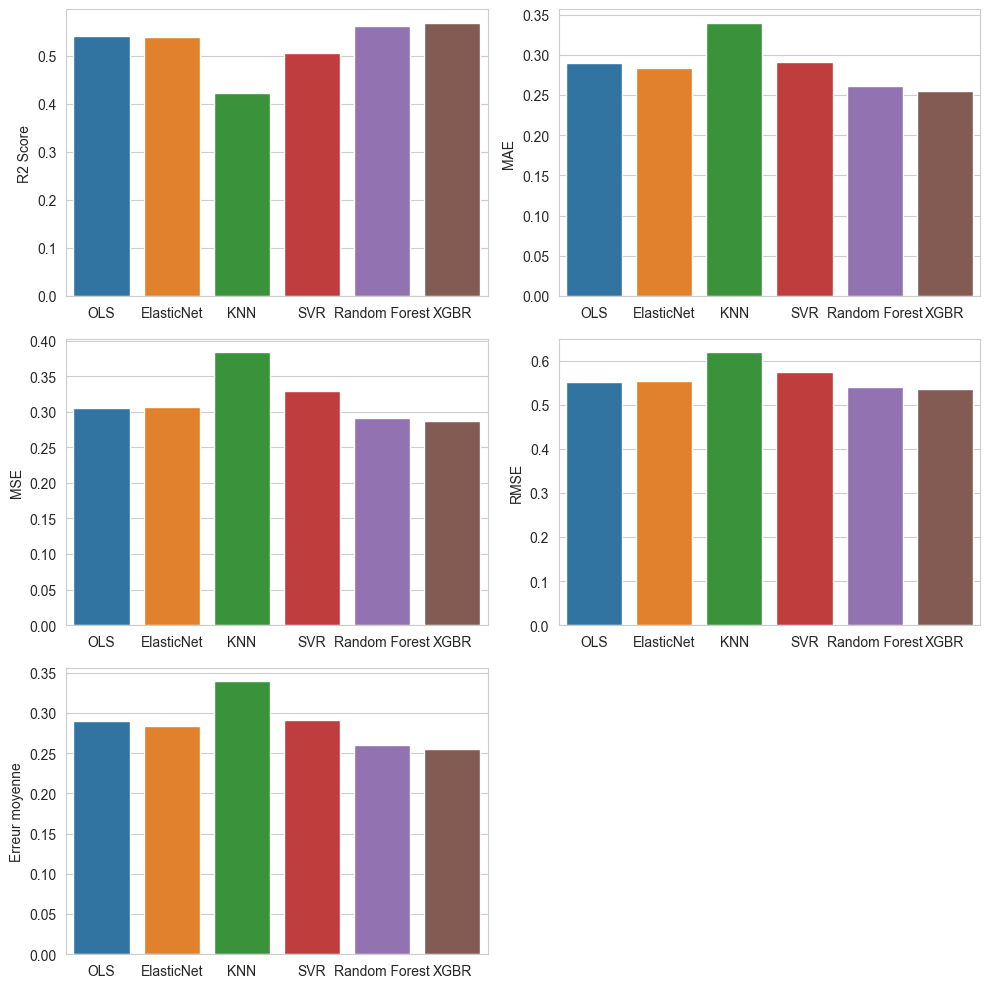

In [98]:
models_viz(resultats_xgb_reg)

In [99]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


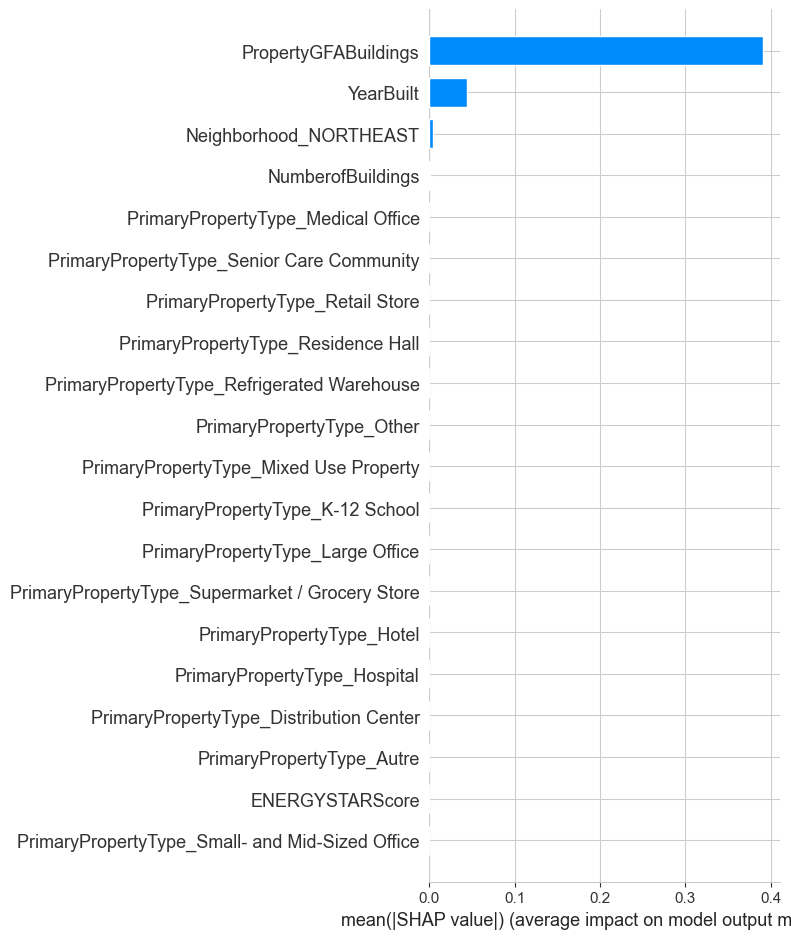

In [100]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


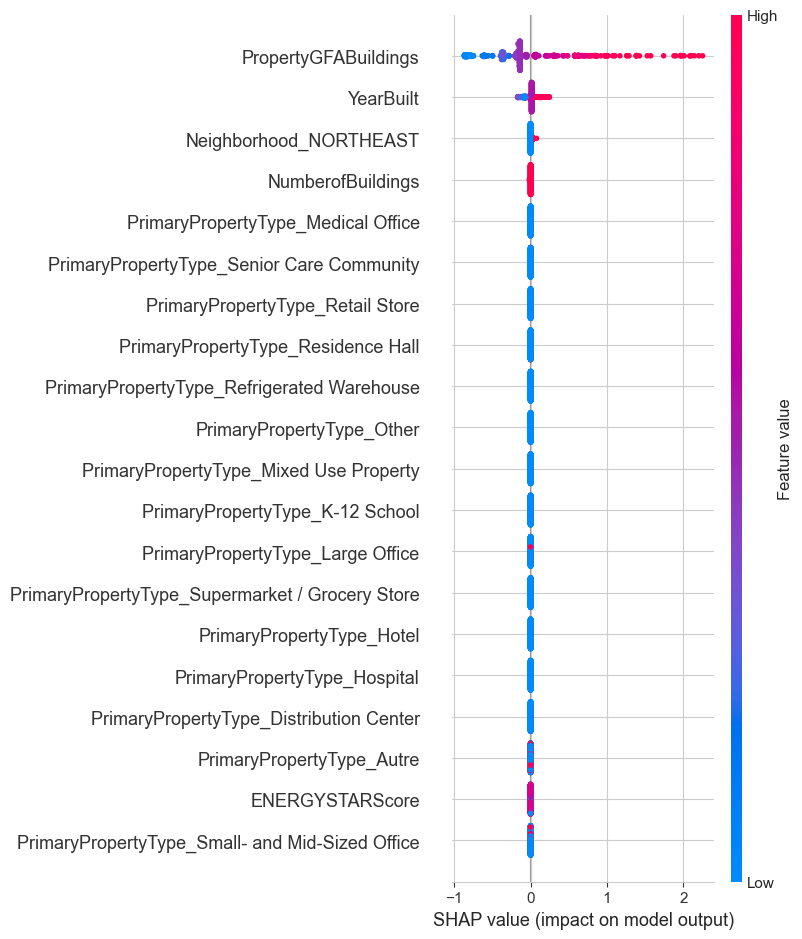

In [101]:
shap.summary_plot(shap_values, X_test)

# Choix du modèle

Après optimisation des hyperparamètres, le modèle Xgboost donnes les meilleurs résultats.
Son efficacité passe de 52,6 % à 56,8%.

Le second modèle pouvant être retenu sera le Random Forest Regressor. Son efficacité passe de 56,8% à 56,17 %.

L’EnergyStarScore n’apporte rien, il semble même dégrader les scores.


Le modèle présentant les meilleures performances tant au niveau résultats, qu'au niveau des métrics est le XGBoost.
Nous choisissons donc ce modèle avec les hyperparamètres suivants :